<a href="https://colab.research.google.com/github/celinagacias/dc-symmetron/blob/main/Data%20Cleaning%20and%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import string
import re
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

# Data Read-In

In [ ]:
#Authenticate user
auth.authenticate_user()
gauth = GoogleAuth()

#Mount GDrive
gdrive = GoogleDrive(gauth)
gauth.credentials = GoogleCredentials.get_application_default()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read data from csv
folder = '1iLA5sSyu7ere1AN40TWRf6O6ma5LoIDl'
filename = 'raw_AACT_data.csv'

gfile_list = gdrive.ListFile({'q': "'" +  folder + "'" + " in parents and trashed=false"}).GetList()
gfile = [f for f in gfile_list if f['title'] == filename][0]
df_file = gdrive.CreateFile({'id': gfile['id']})
df_file.GetContentFile(gfile['title'])
df = pd.read_csv(filename)
display(df.head(2))

,nct_id,start_date,start_date_type,study_type,phase,overall_status,last_known_status,brief_title,population,gender_description,minimum_age,maximum_age,gender,healthy_volunteers,countries_removed,countries_retained,conditions_table,mesh_term,criteria
0,NCT00000113,1997-09-30,NaN,Interventional,Phase 3,Completed,NaN,Correction of Myopia Evaluation Trial (COMET),NaN,NaN,6 Years,12 Years,All,No,{},"{""United States""}",myopia,"eye diseases, myopia, refractive errors",Children between the ages of 6 and 12 years wi...
1,NCT00000114,1984-05-31,NaN,Interventional,Phase 3,Completed,NaN,Randomized Trial of Vitamin A and Vitamin E Su...,NaN,NaN,18 Years,49 Years,All,NaN,NaN,NaN,retinitis pigmentosa,"eye diseases, retinal diseases, retinitis pigm...",Men and nonpregnant women between ages 18 and ...


In [ ]:
n = len(df)
print(f'There are {n} studies in our sample.')

There are 42299 studies in our sample.


# Data Cleaning

In [ ]:
# list of major cancer categories
categories = sorted(['digestive','respiratory tract','head and neck'],
                    key=lambda x: -len(df[df.mesh_term.fillna('').str.contains(x)]))

## Dates

In [ ]:
# convert start date to date
df['start_date'] = df['start_date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d').date() if str(x) != 'nan' else None)

In [ ]:
# extract year into separate column
df['start_year'] = df['start_date'].apply(lambda x: int(x.year) if x is not None else None)

## Countries

In [ ]:
def process_countries(l):
  # converts string of list of countries into lists
  l = l.replace('{','').replace('}','').split(',')
  l = set([c.replace('"','') for c in l])
  return l

In [ ]:
# apply the function to each list of countries
df['countries_removed'] = df['countries_removed'].apply(
    lambda x: process_countries(x) if str(x) != 'nan' else None)

df['countries_retained'] = df['countries_retained'].apply(
    lambda x: process_countries(x) if str(x) != 'nan' else None)

## Ages

In [ ]:
def parse_age(a):
  # Convert text of age into years
  if str(a) == 'nan':
    return np.nan

  num = int(str(a).split(' ')[0])
  if 'Year' in a:
    age = num
  elif 'Month' in a:
    age = num / 12
  elif 'Week' in a:
    age = num / 52
  elif 'Day':
    age = num / 365
  elif 'Hour' in a:
    age = num / (24 * 365)
  elif 'Minute' in a:
    age = num / (24 * 365 * 60)
  return age

df['minimum_age'] = df['minimum_age'].apply(parse_age)
df['maximum_age'] = df['maximum_age'].apply(parse_age)

## Inclusion/Exclusion Criteria

In [ ]:
# identify which studies have clear inclusion vs. exclusion
df['criteria_norm'] = df.criteria.fillna('').str.upper().str.strip().str.replace(' CRITERIA','')
inc_cond = df.criteria_norm.str.contains('INCLUSION:')
exc_cond = df.criteria_norm.str.contains('EXCLUSION:')
parse_mask = (inc_cond) & (exc_cond)
len_parse = df[parse_mask].shape[0]
print(f'There are {len_parse} ({np.round(len_parse*100/n, 2)}%) studies with clearly delineated inclusion/exclusion criteria')

There are 38232 (90.39%) studies with clearly delineated inclusion/exclusion criteria


In [ ]:
def parse_criteria(c):
  '''Splits criteria into inclusion and exclusion'''

  def clean_criteria(s):
    # sub-function to clean up criteria text
    s = s.replace('INCLUSION:','').strip() # remove inclusion title
    s = re.sub(r'(\n\s*)+\n+', '\n', s) # reduce newlines
    return s

  # create list with [inclusion, exclusion]
  c_list = c.split('EXCLUSION:')
  c_list = [clean_criteria(s) for s in c_list]
  return c_list

# apply the function to derive inclusion and exclusion
df['inclusion'] = None
df['exclusion'] = None
df.loc[parse_mask, 'criteria_split'] = df.loc[parse_mask, 'criteria_norm'].apply(parse_criteria)
df.loc[parse_mask, 'inclusion'] = df.loc[parse_mask, 'criteria_split'].apply(lambda x: x[0])
df.loc[parse_mask, 'exclusion'] = df.loc[parse_mask, 'criteria_split'].apply(lambda x: x[1])

## Subsetting

In [ ]:
# remove studies that were paused or suspended
suspend_mask = (df.overall_status.isin(['Terminated', 'Withdrawn', 'Suspended']))
n_suspend = df[suspend_mask].shape[0]
print(f'There are {n_suspend} studies that need to be removed because they are either terminated, withdrawn, or suspended.')
df = df[~suspend_mask].copy(deep=True)
print(f'There are {len(df)} studies remaining.')

There are 4600 studies that need to be removed because they are either terminated, withdrawn, or suspended.
There are 37699 studies remaining.


In [ ]:
# obtain subset of cancer studies
df = df[(df.mesh_term.str.contains('neoplasm')) | 
        (df.mesh_term.str.contains('carcinoma')) | 
        (df.mesh_term.str.contains('cancer'))].copy(deep=True)
print(f'There are {len(df)} studies for cancer-related interventions.')

There are 7385 studies for cancer-related interventions.


In [ ]:
# subset to just the studies that fit into just 1 category

# obtain the applicable categories for each study, in a list
df['category'] = df.mesh_term.apply(lambda x: sorted([c for c in categories if c in x]))
df = df[df.category.apply(lambda x: len(x) == 1)].copy(deep=True)
df['category'] = df.category.apply(lambda x: x[0])
print(f'There are {len(df)} studies that fit into just 1 of the categories we identified')

There are 2498 studies that fit into just 1 of the categories we identified


# Initial Analysis

## Basic Descriptives

In [ ]:
# most common mesh terms
mesh_list = df.mesh_term.apply(lambda x: x.split(', '))
all_mesh = [t for t in list(itertools.chain.from_iterable(mesh_list)) if \
            any([t.startswith(s) for s in ['neoplasm','cancer','carcinoma']]) is False]
mesh_freq = pd.Series(all_mesh).value_counts()
display(mesh_freq.head(30))

digestive system diseases      1324
digestive system neoplasms     1298
gastrointestinal diseases       859
gastrointestinal neoplasms      842
respiratory tract diseases      814
thoracic neoplasms              809
respiratory tract neoplasms     807
lung diseases                   804
lung neoplasms                  800
bronchial neoplasms             674
bronchogenic                    674
glandular and epithelial        644
intestinal diseases             591
intestinal neoplasms            585
colorectal neoplasms            581
non-small-cell lung             577
rectal diseases                 482
colonic diseases                461
adenocarcinoma                  352
head and neck neoplasms         333
liver diseases                  297
liver neoplasms                 289
hepatocellular                  230
stomach diseases                228
stomach neoplasms               225
endocrine system diseases       214
endocrine gland neoplasms       212
pathologic processes        

In [ ]:
# no. of studies per set of categories
print('no. of studies per category or set of categories')
all_cat_count = df.category.value_counts()
all_cat_prop = all_cat_count / len(df)
display(all_cat_count)
display(all_cat_prop)

# # no. of studies per category
# print('''======================
# no. of studies per category''')
# all_cat = list(itertools.chain.from_iterable(df.category))
# cat_count = pd.Series(all_cat).value_counts(dropna=False)
# cat_prop = cat_count / len(df)
# display(cat_count)
# display(cat_prop)

no. of studies per category or set of categories


digestive            1342
respiratory tract     823
head and neck         333
Name: category, dtype: int64

digestive            0.537230
respiratory tract    0.329464
head and neck        0.133307
Name: category, dtype: float64

## By Age

Perform analysis of excluded age groups

In [ ]:
def get_ages(min, max):
  reference_ages = set( range(0, 101) )
  if str(min) != 'nan' and str(max) != 'nan':
    inc = set( range( int(min), int(max)+1 ) )
  elif str(min) == 'nan' and str(max) != 'nan':
    inc = set( range(0, int(max)+1 ) )
  elif str(min) != 'nan' and str(max) == 'nan':
    inc = set( range( int(min), 101) )
  else:
    inc = reference_ages
  exc = sorted(list(reference_ages - inc))
  return exc

df['excluded_ages'] = df.apply(lambda x: get_ages(x.minimum_age, x.maximum_age), axis=1) 

display( df[['minimum_age', 'maximum_age', 'excluded_ages']].head() )

,minimum_age,maximum_age,excluded_ages
203,50.0,79.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
354,20.0,80.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
360,18.0,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
365,18.0,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
368,20.0,80.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


There are 1324 clinical trials for digestive system.
There are 825 clinical trials for respiratory.
There are 333 clinical trials for head and neck.
There are 23 clinical trials for breast.
There are 15 clinical trials for lymphatic.
There are 13 clinical trials for lymphoproliferative.
There are 13 clinical trials for immunoproliferative.
There are 9 clinical trials for leukemia.


(array([  0.5,   5.5,  10.5,  15.5,  20.5,  25.5,  30.5,  35.5,  40.5,
         45.5,  50.5,  55.5,  60.5,  65.5,  70.5,  75.5,  80.5,  85.5,
         90.5,  95.5, 100.5]),
 [Text(0, 0.5, '100'),
  Text(0, 5.5, '95'),
  Text(0, 10.5, '90'),
  Text(0, 15.5, '85'),
  Text(0, 20.5, '80'),
  Text(0, 25.5, '75'),
  Text(0, 30.5, '70'),
  Text(0, 35.5, '65'),
  Text(0, 40.5, '60'),
  Text(0, 45.5, '55'),
  Text(0, 50.5, '50'),
  Text(0, 55.5, '45'),
  Text(0, 60.5, '40'),
  Text(0, 65.5, '35'),
  Text(0, 70.5, '30'),
  Text(0, 75.5, '25'),
  Text(0, 80.5, '20'),
  Text(0, 85.5, '15'),
  Text(0, 90.5, '10'),
  Text(0, 95.5, '5'),
  Text(0, 100.5, '0')])

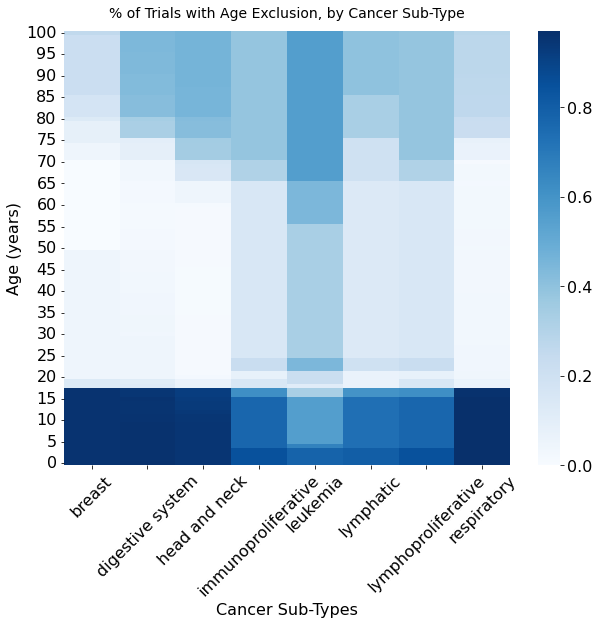

In [47]:
# obtain subset of cancer studies
cancer = df[(df.mesh_term.str.contains('neoplasm')) | 
            (df.mesh_term.str.contains('cancer'))].copy(deep=True)

# for obtaining the "exclusion rate" per age from 0-100 based on a search term
search_term = 'digestive system'
def count_age_exclude(search_term, cancer=cancer):

  def count_trials(sub, age):
    where_excluded = sub[sub.excluded_ages.apply(lambda x: age in x)]
    no_excluded = len(where_excluded)
    return no_excluded

  sub = cancer[cancer.mesh_term.str.contains(search_term)].copy(deep=True)
  n = len(sub)
  print(f'There are {n} clinical trials for {search_term}.')
  ages = list( range(0,101) )
  percent_trials = [count_trials(sub, age)/n for age in ages]
  result = pd.DataFrame({
    'age': ages,
    'sub_type': [search_term] * len(ages),
    'percent_trials': percent_trials
  })
  return result

# for obtaining the same thing for multiple search terms
search_terms = sorted(['respiratory', 'lymphoproliferative', 'lymphatic', 
                       'leukemia', 'immunoproliferative', 'head and neck', 
                       'digestive system', 'breast'],
key=lambda x: -len(cancer[cancer.mesh_term.str.contains(x)]))
tables = [count_age_exclude(term) for term in search_terms]
lt = pd.concat(tables)

# pivot from long to wide
lt_wide = pd.pivot(lt, index='age', columns = 'sub_type', values = 'percent_trials')
lt_wide.sort_values('age', ascending=False, inplace=True)

# generate heat map
plt.figure(figsize=(10, 8))
sns.heatmap(lt_wide, yticklabels=5, cmap="Blues")
plt.title('% of Trials with Age Exclusion, by Cancer Sub-Type', pad=13, fontsize=14)
plt.xlabel("Cancer Sub-Types")
plt.xticks(rotation=45)
plt.ylabel("Age (years)")
plt.yticks(rotation=0)

## By Gender

Simple descriptive statistics of gender column:

In [ ]:
# Overall gender percentages across all cancer groups:
gender_percentages_overall = df.gender.value_counts(normalize=True) * 100
gender_percentages_overall

All       97.835671
Female     1.843687
Male       0.320641
Name: gender, dtype: float64

Gender proportions by cancer type: 

In [ ]:
def obtain_gender_percent(term, df=df):
  # obtain subset of trials with search term
  mask = df.mesh_term.fillna('').str.contains(term)
  sub = df[mask].copy(deep=True)
  gender_prop = sub['gender'].value_counts(normalize = True) * 100

  # summarize gender percent
  table = pd.DataFrame(gender_prop).reset_index()
  table.rename(columns={'index': 'gender', 'gender': 'percent'}, inplace=True)
  table['condition'] = term
  return table

percent_tables = [obtain_gender_percent(cat) for cat in categories]
percent_all = pd.concat(percent_tables)
percent_all

,gender,percent,condition
0,All,99.634592,respiratory tract
1,Female,0.243605,respiratory tract
2,Male,0.121803,respiratory tract
0,All,96.497765,digestive
1,Female,3.204173,digestive
2,Male,0.298063,digestive
0,All,98.795181,head and neck
1,Male,0.903614,head and neck
2,Female,0.301205,head and neck


<Figure size 1152x720 with 0 Axes>

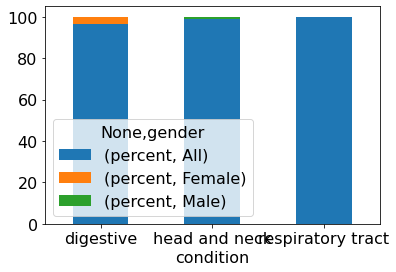

In [65]:
# sns.barplot(percent_all, by='condition', color='gender', stacked=True)
# percent_all.set_index('condition').plot(kind='bar', color='gender', stacked=True)
percent_wide = pd.pivot(percent_all, index='condition', columns=['gender'], values=['percent'])
plt.figure(figsize=(16,10))
ax = percent_wide.plot(kind='bar', stacked=True)
# ax.get_legend().remove()
plt.xticks(rotation=0)
plt.show()

## Exclusion Criteria

In [ ]:
# summarize no. of studies with separable criteria
with_crit = (df.inclusion.notnull() & df.exclusion.notnull()).value_counts()
print(f'''No. of studies with distinct inclusion and exclusion criteria: 
{with_crit}''')

No. of studies with distinct inclusion and exclusion criteria: 
True     2088
False     410
dtype: int64


In [ ]:
import nltk
import itertools
import string

from nltk.util import everygrams
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

# remove punctuation and stopwords
clean_string = lambda x: ' '.join([w for w in x.translate(str.maketrans('', '', string.punctuation)).split() \
                                   if w.lower() not in stopwords and w.isdigit() is False]) \
                                   if x is not None else None
df['exclusion_clean'] = df['exclusion'].apply(clean_string).fillna('')

# view common n-grams (length of 2 to 4)
to_ngram = lambda x: set(everygrams(x.split(), min_len=2, max_len=4)) if x != '' else None
ngrams = df.exclusion_clean.apply(to_ngram)
all_ngrams = list(itertools.chain.from_iterable([s for s in ngrams if s is not None]))
ngram_count = pd.Series(all_ngrams).value_counts()
display( ngram_count.head(50) )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(WITHIN, DAYS)                           511
(MYOCARDIAL, INFARCTION)                 492
(HEART, FAILURE)                         474
(WITHIN, WEEKS)                          470
(WITHIN, MONTHS)                         409
(CELL, CARCINOMA)                        381
(CONGESTIVE, HEART)                      379
(CONGESTIVE, HEART, FAILURE)             372
(BASAL, CELL)                            349
(CARCINOMA, SITU)                        348
(DAYS, PRIOR)                            344
(HEPATITIS, B)                           344
(SKIN, CANCER)                           338
(CENTRAL, NERVOUS)                       331
(NERVOUS, SYSTEM)                        329
(CENTRAL, NERVOUS, SYSTEM)               323
(ACTIVE, INFECTION)                      318
(CLINICALLY, SIGNIFICANT)                317
(WEEKS, PRIOR)                           316
(UNSTABLE, ANGINA)                       313
(PREGNANT, LACTATING)                    305
(WITHIN, DAYS, PRIOR)                    293
(HUMAN, IM

,exclusion_criteria,no_trials,total_trials,percent_trials
3,pregnant,1215,2498,48.638911
0,heart_issues,1044,2498,41.793435
4,breastfeeding,584,2498,23.378703
2,hiv,538,2498,21.537230
1,hepatitis,459,2498,18.374700
5,major_surgery,324,2498,12.970376


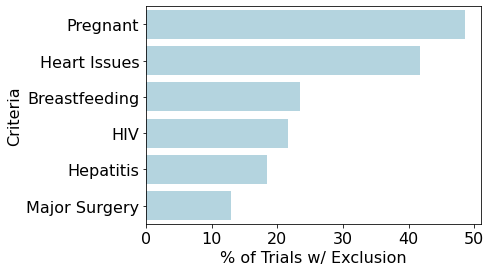

In [ ]:
pd.set_option('max_rows', None)
pd.set_option('max_colwidth', None)

keywords = {
    'heart_issues': ['CONGESTIVE HEART','HEART FAILURE','ANGINA','ISCHEMIC HEART',
                     'CORONARY DISEASE','HYPERTENSION','MYOCARDIAL',
                     'CARDIAC','CARDIOVASC','ARRHYTHMIA','ARRYTHMIA'],
    'hepatitis': ['HEPATITIS'],
    'hiv': ['HIV-','-HIV',',HIV','HIV/AIDS','(HIV)','KNOWN HIV',
            'PROVEN HIV','HIV POSITIV','HIV-POSITIV','HUMAN IMMUNODEFICIENCY',
            'OR HIV','HIV INFECT','HIV-INFECT',' HIV'],
    'pregnant': ['PREGNAN'],
    'breastfeeding': ['LACTATING', 'BREASTFEED'],
    'major_surgery': ['MAJOR SURG']
}

# to add:
# central nervous system
# major surgery

exclusion_dfs = []

for key in keywords.keys():
  search_terms = keywords[key]
  terms_col = f'{key}_terms'
  df[terms_col] = df.exclusion.apply(lambda x: [term for term in search_terms if term in x] \
                                     if x is not None else [])
  df[key] = df[terms_col].apply(lambda x: len(x) > 0)

  # summarize the % of studies per category
  for c in categories:
    cat_mask = (df.category.apply(lambda x: c in x))
    exclusion_sub = {
        'exclusion_criteria': key,
        'cancer_category': c,
        'no_trials': len(df[df[key] & cat_mask]),
        'total_trials': len(df[cat_mask]),
        'percent_trials': len(df[df[key] & cat_mask])*100 / len(df[cat_mask])
    }
    exclusion_dfs.append(exclusion_sub)

# create top-level summary of exclusion criteria present
exc_top = df[list(keywords.keys())].agg(['sum','mean']).transpose().reset_index()
exc_top.rename(columns = {'index': 'exclusion_criteria', 
                          'sum': 'no_trials',
                          'mean': 'percent_trials'}, inplace=True)
exc_top['no_trials'] = exc_top['no_trials'].astype(int)
exc_top['total_trials'] = len(df)
exc_top['percent_trials'] = exc_top['percent_trials'] * 100
exc_top = exc_top[['exclusion_criteria', 'no_trials', 'total_trials', 'percent_trials']]
exc_top.sort_values('no_trials', ascending=False, inplace=True)
display(exc_top)

# plot the top-level summary
criteria_map = {
    'pregnant': 'Pregnant',
    'heart_issues': 'Heart Issues',
    'breastfeeding': 'Breastfeeding',
    'hiv': 'HIV',
    'hepatitis': 'Hepatitis',
    'major_surgery': 'Major Surgery'
}
exc_top['exclusion_criteria'] = exc_top['exclusion_criteria'].map(criteria_map)
ax = sns.barplot(data=exc_top, x='percent_trials', y='exclusion_criteria',
            color='lightblue')
ax.set_xlabel('% of Trials w/ Exclusion')
ax.set_ylabel('Criteria')
plt.show()

# collect per-criteria summaries into one table
exc_summary = pd.DataFrame(exclusion_dfs).sort_values(['cancer_category','exclusion_criteria'])

no_trials
cancer_category   exclusion_criteria           
digestive         heart_issues              593
                  hepatitis                 182
                  hiv                       255
                  pregnant                  690
                  breastfeeding             322
                  major_surgery             151
head and neck     heart_issues              119
                  hepatitis                  69
                  hiv                        61
                  pregnant                  183
                  breastfeeding              80
                  major_surgery              23
respiratory tract heart_issues              332
                  hepatitis                 208
                  hiv                       222
                  pregnant                  342
                  breastfeeding             182
                  major_surgery             150

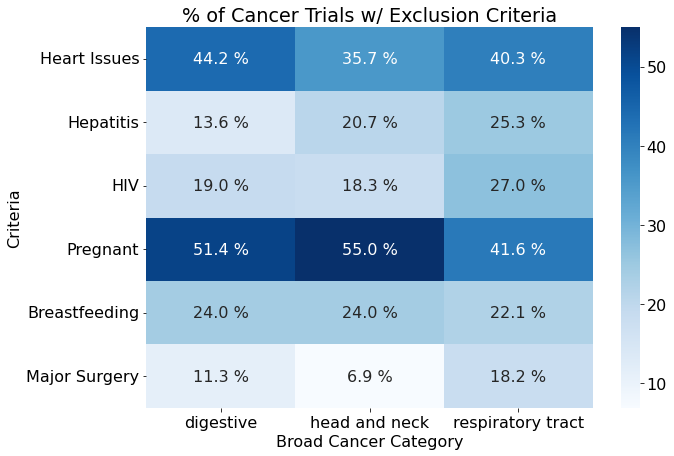

In [ ]:
## generate heatmap

# sort exclusion criteria by no. of studies affected
order = sorted(keywords.keys(), key=lambda x: len(df[x]), reverse=True)
exc_summary['exclusion_criteria'] = pd.Categorical(exc_summary['exclusion_criteria'], order)
exc_wide = pd.pivot(exc_summary[['exclusion_criteria','cancer_category','percent_trials']].copy(deep=True), 
                    index='exclusion_criteria', 
                    columns = 'cancer_category', 
                    values = 'percent_trials')

# display the no. of trials by cancer category and exclusion criteria
exc_count = exc_summary.groupby(['cancer_category','exclusion_criteria']).no_trials.sum().to_frame()
display(exc_count)

# plot the wide-format table
exc_wide.index = exc_wide.index.values.map(criteria_map)
plt.figure(figsize=(10,7))
ax = sns.heatmap(exc_wide, cmap="Blues", annot=True, fmt = '.1f')
ax.patch.set_facecolor('xkcd:white')
ax.set_title('% of Cancer Trials w/ Exclusion Criteria')
ax.set_ylabel('Criteria')
ax.set_xlabel('Broad Cancer Category')
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.xticks(rotation=0)
plt.show()

In [ ]:
exc_wide.index.values

['heart_issues', 'hepatitis', 'hiv', 'pregnant', 'breastfeeding', 'major_surgery']
Categories (6, object): ['heart_issues', 'hepatitis', 'hiv', 'pregnant', 'breastfeeding',
                         'major_surgery']

In [ ]:
exc_wide['exclusion_criteria'] = exc_wide['exclusion_criteria'].map(criteria_map)


cancer_category,digestive,head and neck,respiratory tract
exclusion_criteria,,,
heart_issues,44.187779,35.735736,40.340219
hepatitis,13.561848,20.720721,25.273390
hiv,19.001490,18.318318,26.974484
pregnant,51.415797,54.954955,41.555286
breastfeeding,23.994039,24.024024,22.114216
major_surgery,11.251863,6.906907,18.226002


# Creating Graphs

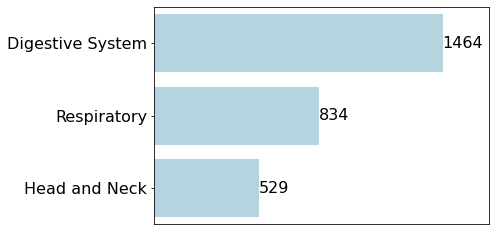

In [ ]:
# No. of trials by cancer category
no_trials = pd.DataFrame({
    'Cancer Category': ['Digestive System', 'Respiratory', 'Head and Neck'],
    'No. of Trials': [1464, 834, 529]
})

plt.rcParams.update({'font.size': 16})
ax = sns.barplot(data = no_trials, x='No. of Trials', y='Cancer Category',color = 'lightblue')
ax.set_xticks([])
ax.set_xlabel(None)
ax.bar_label(ax.containers[0])
ax.set_xlim(0,1700)
ax.set_ylabel(None)
plt.show()

In [ ]:
raise Exception("scratch code below")

Exception: ignored